In [12]:
#pip install openai-whisper

In [13]:
#pip install transformers torch

version1


In [31]:
from transformers import AutoTokenizer, pipeline
import numpy as np

import warnings
# Targeted warning suppression
# warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", message=".*Token indices sequence length.*")
warnings.filterwarnings("ignore", category=UserWarning,
                        module="transformers")

# Transcribe audio using Whisper
def transcribe_audio(file_path):
    model = whisper.load_model("base")
    result = model.transcribe(file_path)
    return result["text"]

# Chunk text with overlap and analyze sentiment
def analyze_long_text(text, model_name="bert-large-uncased"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)

    # Tokenize and chunk with 15% overlap
    tokens = tokenizer.tokenize(text)
    max_length = 450  # 512 - 62 tokens for overlap
    overlap = 62
    chunks = []

    for i in range(0, len(tokens), max_length - overlap):
        chunk_tokens = tokens[i:i + max_length]
        chunks.append(tokenizer.convert_tokens_to_string(chunk_tokens))

    # Process chunks and aggregate results
    sentiments = []
    for chunk in chunks:
        result = sentiment_analyzer(chunk)[0]
        score = result['score'] * (1 if result['label'] == 'POSITIVE' else -1)
        sentiments.append(score)

    # Calculate weighted average
    avg_score = np.mean(sentiments)
    final_label = 'POSITIVE' if avg_score >= 0 else 'NEGATIVE'

    return {
        'label': final_label,
        'score': abs(avg_score),
        'chunks_processed': len(chunks)
    }

# Main execution
if __name__ == "__main__":
    text = transcribe_audio("/content/Assignment3.mp4")
    print("Audio text:\n",text)
    analysis = analyze_long_text(text)

    print(f"Final Sentiment: {analysis['label']} | Confidence: {analysis['score']:.2f}")
    print(f"Processed {analysis['chunks_processed']} text chunks")

    result = generate_summary(text)
    print("Generated Summary:\n", result['summary'])


Audio text:
  So, everyone, for today's assignment, I would like to discuss about my block code design for the Neon Ascent game which I am thinking to design. This is the Mechanics Experience School Unlayout which I provided in previous assignments. In this assignment, I created the Neon Ascent with block codes and if you can see in Blender, this is how the design will be. And I tried to create one more layer but for now I created only up to two layers and the layer will start from here. And he will enter by searching like I, there is block or not and better than that contest, he will move here and I provided some guidelines so that he can take these steps. And from there, the real task begins like he need to figure it out like how he need to move to the next level for that he need to jump here where there will be movement and this is the pentagonal shape which I created where he need to travel on this until he find the way like if you see here, this is the other design where this is t

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


Final Sentiment: NEGATIVE | Confidence: 0.57
Processed 2 text chunks


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu



Generated Summary (TL;DR):
  This is the Mechanics Experience School Unlayout which I provided in previous assignments . In this assignment, I created the Neon Ascent with block codes and if you can see in Blender, this is how the design will be . And I tried to create one more layer but for now I created only up to two layers and the layer will start from here . And he will enter by searching like I, there is block or not and better than that contest, he will move here and I provided some guidelines so that he can take these steps . And from there, the real task begins like he need to figure it out like how he need

Bullet Points Summary:
• This is the Mechanics Experience School Unlayout which I provided in previous assignments
• In this assignment, I created the Neon Ascent with block codes and if you can see in Blender, this is how the design will be
• And I tried to create one more layer but for now I created only up to two layers and the layer will start from here
• And he will 

version2


In [30]:
from transformers import AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
import numpy as np
import whisper
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# ----- Core Meeting Processing Functions -----

def transcribe_audio(file_path):
    """Transcribe audio using Whisper with GPU acceleration"""
    model = whisper.load_model("base")
    result = model.transcribe(file_path)
    return result["text"]

def analyze_sentiment(text):
    """Analyze sentiment with chunking and context preservation"""
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english",
        tokenizer=tokenizer
    )

    # Context-aware chunking
    chunk_size = 400
    overlap = 50
    chunks = [
        text[i:i+chunk_size]
        for i in range(0, len(text), chunk_size - overlap)
    ]

    sentiments = []
    for chunk in chunks:
        result = sentiment_analyzer(chunk[:512])[0]
        score = result['score'] * (1 if result['label'] == 'POSITIVE' else -1)
        sentiments.append(score)

    avg_score = np.mean(sentiments) if sentiments else 0
    return {
        'label': 'POSITIVE' if avg_score >= 0 else 'NEGATIVE',
        'score': abs(avg_score),
        'chunks': len(chunks)
    }

def generate_summary(text):
    """Generate intelligent meeting summary with hierarchical processing"""
    summarizer = pipeline(
        "summarization",
        model="philschmid/bart-large-cnn-samsum",
        tokenizer="philschmid/bart-large-cnn-samsum"
    )

    # Hierarchical summarization for long meetings
    if len(text) > 1500:
        chunks = [text[i:i+1000] for i in range(0, len(text), 800)]
        chunk_summaries = [summarizer(c, max_length=150, min_length=30)[0]['summary_text'] for c in chunks]
        combined = " ".join(chunk_summaries)
        return summarizer(combined, max_length=300, min_length=50)[0]['summary_text']

    return summarizer(text, max_length=300, min_length=50)[0]['summary_text']

def extract_action_items(text):
    """Extract action items using pattern matching"""
    nlp = pipeline("ner", model="dslim/bert-base-NER")
    actions = []
    for sent in text.split('.'):
        if 'need to' in sent or 'should' in sent:
            entities = nlp(sent)
            owners = [e['word'] for e in entities if e['entity'] == 'PER']
            actions.append({
                "action": sent.strip(),
                "owners": list(set(owners)),
                "priority": "high" if 'urgent' in sent else "normal"
            })
    return actions

# ----- Main Workflow -----

def process_meeting(file_path):
    """End-to-end meeting processing pipeline"""
    print("⏳ Transcribing audio...")
    transcript = transcribe_audio(file_path)

    print("🔍 Analyzing content...")
    return {
        "transcript": transcript,
        "summary": generate_summary(transcript),
        "sentiment": analyze_sentiment(transcript),
        "action_items": extract_action_items(transcript)
    }

if __name__ == "__main__":
    input_file = "/content/Assignment3.mp4"

    print(f"🚀 Processing {input_file}...")
    results = process_meeting(input_file)

    print("\n📝 Transcript Excerpt:\n", results['transcript'][:500] + "...")
    print("\n💡 Meeting Summary:\n", results['summary'])
    print(f"\n🎭 Overall Sentiment: {results['sentiment']['label']} ({results['sentiment']['score']:.2f})")

    if results['action_items']:
        print("\n✅ Action Items:")
        for i, action in enumerate(results['action_items'], 1):
            print(f"{i}. {action['action']}")
            print(f"   Owners: {', '.join(action['owners']) or 'Unassigned'}")
            print(f"   Priority: {action['priority']}\n")


🚀 Processing /content/Assignment3.mp4...
⏳ Transcribing audio...
🔍 Analyzing content...


config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
Your max_length is set to 150, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 300, but your input_length is only 201. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=100)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu



📝 Transcript Excerpt:
  So, everyone, for today's assignment, I would like to discuss about my block code design for the Neon Ascent game which I am thinking to design. This is the Mechanics Experience School Unlayout which I provided in previous assignments. In this assignment, I created the Neon Ascent with block codes and if you can see in Blender, this is how the design will be. And I tried to create one more layer but for now I created only up to two layers and the layer will start from here. And he will enter by...

💡 Meeting Summary:
 Today's assignment is to discuss block code design for the Neon Ascent game. In previous assignments, I provided the layout for the Mechanics Experience School Unlayout. In this assignment, I created the design with block codes. After testing the environment, the designer wants to add more layers to the game and make it more challenging.

🎭 Overall Sentiment: NEGATIVE (0.72)

✅ Action Items:
1. And from there, the real task begins like he need to 

Transcribed text and generated summary - Final version


In [33]:
from transformers import AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
import numpy as np
import warnings
import whisper

warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# Transcribe audio using Whisper
def transcribe_audio(file_path):
    model = whisper.load_model("base")
    result = model.transcribe(file_path)
    return result["text"]

# Chunk text with overlap and analyze sentiment
def analyze_long_text(text, model_name="bert-large-uncased"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)

    tokens = tokenizer.tokenize(text)
    max_length = 450
    overlap = 62
    chunks = []

    for i in range(0, len(tokens), max_length - overlap):
        chunk_tokens = tokens[i:i + max_length]
        chunks.append(tokenizer.convert_tokens_to_string(chunk_tokens))

    sentiments = []
    for chunk in chunks:
        result = sentiment_analyzer(chunk)[0]
        score = result['score'] * (1 if result['label'] == 'POSITIVE' else -1)
        sentiments.append(score)

    avg_score = np.mean(sentiments)
    final_label = 'POSITIVE' if avg_score >= 0 else 'NEGATIVE'

    return {
        'label': final_label,
        'score': abs(avg_score),
        'chunks_processed': len(chunks)
    }

# Generate TL;DR and bullet point summaries
def generate_summary(text, model_name="sshleifer/distilbart-cnn-12-6"):
    summarizer = pipeline("summarization", model=model_name)

    max_input_length = 1024
    chunk_size = 900
    overlap = 100

    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i + chunk_size])
        chunks.append(chunk)

    summaries = [summarizer(chunk, max_length=130, min_length=30, do_sample=False)[0]['summary_text'] for chunk in chunks]
    full_summary = " ".join(summaries)

    # Optional: Convert summary to bullet points
    bullets = ["• " + sentence.strip() for sentence in full_summary.split('.') if sentence.strip()]

    return {
        'summary': full_summary,
        'bullet_points': bullets
    }

# Main execution
if __name__ == "__main__":
    text = transcribe_audio("/content/Assignment3.mp4")
    print("Audio text:\n", text)

    analysis = analyze_long_text(text)
    print(f"Final Sentiment: {analysis['label']} | Confidence: {analysis['score']:.2f}")
    print(f"Processed {analysis['chunks_processed']} text chunks")

    result = generate_summary(text)
    print("\n💡 Generated Summary (TL;DR):\n", result['summary'])
    # print("\n✅ Bullet Points Summary:")
    # for bullet in result['bullet_points']:
    #     print(bullet)


Audio text:
  So, everyone, for today's assignment, I would like to discuss about my block code design for the Neon Ascent game which I am thinking to design. This is the Mechanics Experience School Unlayout which I provided in previous assignments. In this assignment, I created the Neon Ascent with block codes and if you can see in Blender, this is how the design will be. And I tried to create one more layer but for now I created only up to two layers and the layer will start from here. And he will enter by searching like I, there is block or not and better than that contest, he will move here and I provided some guidelines so that he can take these steps. And from there, the real task begins like he need to figure it out like how he need to move to the next level for that he need to jump here where there will be movement and this is the pentagonal shape which I created where he need to travel on this until he find the way like if you see here, this is the other design where this is t

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


Final Sentiment: NEGATIVE | Confidence: 0.55
Processed 2 text chunks


Device set to use cpu



💡 Generated Summary (TL;DR):
  This is the Mechanics Experience School Unlayout which I provided in previous assignments . In this assignment, I created the Neon Ascent with block codes and if you can see in Blender, this is how the design will be . And I tried to create one more layer but for now I created only up to two layers and the layer will start from here . And he will enter by searching like I, there is block or not and better than that contest, he will move here and I provided some guidelines so that he can take these steps . And from there, the real task begins like he need to figure it out like how he need

✅ Bullet Points Summary:
• This is the Mechanics Experience School Unlayout which I provided in previous assignments
• In this assignment, I created the Neon Ascent with block codes and if you can see in Blender, this is how the design will be
• And I tried to create one more layer but for now I created only up to two layers and the layer will start from here
• And he w

action items


In [50]:
from openai import OpenAI
import json

# Initialize client with secure API key handling (use environment variables in production)
client = OpenAI(api_key="")

def analyze_meeting_transcript(text):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": """Generate meeting analysis in this JSON format:
                {
                    "transcript": "full original text",
                    "summary": "condensed summary",
                    "sentiment": {
                        "score": 0.72,
                        "positive": 15,
                        "negative": 3
                    },
                    "action_items": [
                        {"action": , "owner": , "confidence": }
                    ],
                    "speakers": [
                        {"text": , "speaker": }
                    ],
                    "metadata": {
                        "duration": seconds,
                        "language": "en",
                        "model_versions": {"transcription": "whisper-1", "analysis": "gpt-4o"}
                    }
                }"""
            },
            {
                "role": "user",
                "content": text
            }
        ],
        temperature=0.3,
        response_format={"type": "json_object"}
    )

    return json.loads(response.choices[0].message.content)

# Example usage with your transcript
transcript = text  # Paste full transcript here

try:
    analysis = analyze_meeting_transcript(transcript)
    #print(json.dumps(analysis, indent=2))
    print("\nAction Items:")
    for item in analysis["action_items"]:
      print(f"- {item['action']}")
except Exception as e:
    print(f"Error: {str(e)}")



Action Items:
- Add more layers to the game
- Introduce more challenging geometry
- Make modifications based on testing feedback


🔍 Extracting audio features...


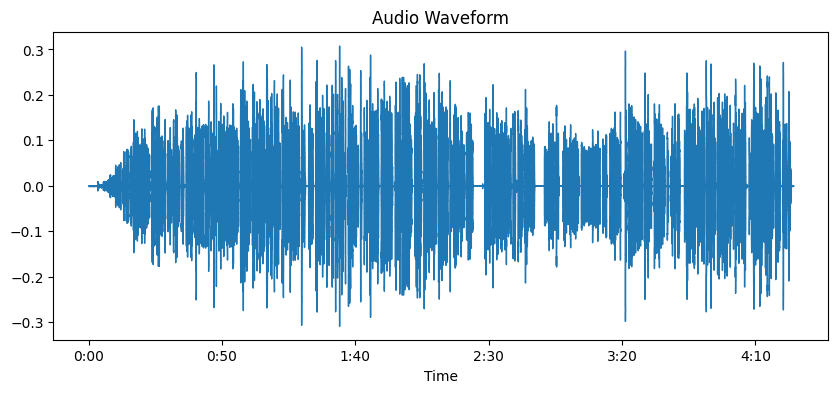

📝 Transcribing audio...
🧠 Analyzing sentiment...


Device set to use cpu



📊 Final Sentiment: NEGATIVE
🔢 Sentiment Score: -0.97
⚡ Intensity: 0.03
📈 Positive Segments: 0
📉 Negative Segments: 4

🎧 Audio Features:
⏱ Duration: 264.21s
🔊 RMS Energy: 0.03
🎚 Zero Crossing Rate: 0.07
📡 Spectral Centroid: 1325.61 Hz


In [51]:
from transformers import pipeline, AutoTokenizer
import numpy as np
import whisper
import librosa
import matplotlib.pyplot as plt

def analyze_audio_tone(file_path):
    """End-to-end audio tone analysis pipeline"""
    # 1. Audio Feature Extraction using Librosa
    print("🔍 Extracting audio features...")
    y, sr = librosa.load(file_path)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Audio Waveform')
    plt.show()

    # 2. Speech-to-Text with Whisper
    print("📝 Transcribing audio...")
    transcriber = whisper.load_model("base")
    result = transcriber.transcribe(file_path)
    text = result["text"]

    # 3. Text-Based Sentiment Analysis with Chunking
    print("🧠 Analyzing sentiment...")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
    analyzer = pipeline("sentiment-analysis",
                      model="distilbert-base-uncased-finetuned-sst-2-english",
                      tokenizer=tokenizer)

    # Improved chunking with sentence preservation
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    chunk_size = 5  # sentences per chunk
    chunks = [' '.join(sentences[i:i+chunk_size]) for i in range(0, len(sentences), chunk_size)]

    sentiments = []
    for chunk in chunks:
        result = analyzer(chunk, truncation=True, max_length=512)[0]
        score = result['score'] * (1 if result['label'] == 'POSITIVE' else -1)
        sentiments.append(score)

    # 4. Composite Sentiment Calculation
    avg_score = np.mean(sentiments)
    sentiment_label = 'POSITIVE' if avg_score >= 0 else 'NEGATIVE'

    # 5. Enhanced Output with Audio Features
    return {
        "transcript": text,
        "sentiment": {
            "label": sentiment_label,
            "score": float(avg_score),
            "intensity": float(np.std(sentiments)),
            "positive_chunks": sum(1 for s in sentiments if s > 0),
            "negative_chunks": sum(1 for s in sentiments if s < 0)
        },
        "audio_features": {
            "duration": len(y)/sr,
            "rms_energy": float(np.sqrt(np.mean(y**2))),
            "zero_crossing_rate": float(np.mean(librosa.feature.zero_crossing_rate(y))),
            "spectral_centroid": float(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
        }
    }

# Usage
if __name__ == "__main__":
    analysis = analyze_audio_tone("/content/Assignment3.mp4")

    print(f"\n📊 Final Sentiment: {analysis['sentiment']['label']}")
    print(f"🔢 Sentiment Score: {analysis['sentiment']['score']:.2f}")
    print(f"⚡ Intensity: {analysis['sentiment']['intensity']:.2f}")
    print(f"📈 Positive Segments: {analysis['sentiment']['positive_chunks']}")
    print(f"📉 Negative Segments: {analysis['sentiment']['negative_chunks']}")

    print("\n🎧 Audio Features:")
    print(f"⏱ Duration: {analysis['audio_features']['duration']:.2f}s")
    print(f"🔊 RMS Energy: {analysis['audio_features']['rms_energy']:.2f}")
    print(f"🎚 Zero Crossing Rate: {analysis['audio_features']['zero_crossing_rate']:.2f}")
    print(f"📡 Spectral Centroid: {analysis['audio_features']['spectral_centroid']:.2f} Hz")
